In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

In [2]:
# define constants
HEIGHT = 8
WIDTH = 8

In [3]:
# intialize board
def init_board():
    # create board environment
    board = np.zeros((HEIGHT, WIDTH)).astype(int)
    # white pieces
    board[[0,2], 1:8:2] = 1
    board[1,0:7:2] = 1
    # black pieces
    board[[5,7], 0:7:2] = 2
    board[6,1:8:2] = 2
    # return
    return board

In [4]:
# convert board to a hashable type
def board_to_state(board):
    res = ''
    for i in range(WIDTH):
        for j in range(HEIGHT):
            res += str(board[i][j])
        res += '\n'
    return res

In [5]:
# function to print out the checker board
# 0 = empty, 1 = white, 2 = black
def print_board(board):
    for i in range(WIDTH):
        for j in range(HEIGHT):
            if (board[i][j] == 1):
                print('|{}'.format('W'), end='')
            elif (board[i][j] == 2):
                print('|{}'.format('B'), end='')
            else:
                print('|{}'.format(' '), end='')
        print('|')

In [6]:
# returns all the valid actions you could take per piece
# board = 2d array of whole state
# player = int stating which player you are
# piece = list of tuples of coordinate of a piece location (i,j)
# action = (piece location, new piece loction, piece taken)
def get_actions(board, player):
    # get all pieces
    pieces = np.argwhere(board == player)
    
    # initialize actions
    valid_actions = []
    
    # if you are white player
    if player == 1:
        # check if each action is valid
        for i,j in pieces:
            # can go down?
            if (i < HEIGHT-1):
                # can go left?
                if (j > 0):
                    # empty space
                    if board[i+1, j-1] == 0:
                        valid_actions.append(((i,j), (i+1,j-1), (-1,-1)))
                    # other player
                    elif board[i+1, j-1] != player:
                        # space to land
                        if (i+2 <= HEIGHT-1) and (j-2 >= 0) and (board[i+2,j-2] == 0):
                            valid_actions.append(((i,j), (i+2,j-2), (i+1,j-1)))
                # can go right?
                if (j < WIDTH-1):
                    # empty space
                    if board[i+1, j+1] == 0:
                        valid_actions.append(((i,j), (i+1,j+1), (-1,-1)))
                    # other player
                    elif board[i+1, j+1] != player:
                        # space to land
                        if (i+2 <= HEIGHT-1) and (j+2 <= WIDTH-1) and (board[i+2,j+2] == 0):
                            valid_actions.append(((i,j), (i+2,j+2), (i+1,j+1)))
    # if you are black player
    elif player == 2:
        # check if each action is valid
        for i,j in pieces:
            # can go up?
            if (i > 0):
                # can go left?
                if (j > 0):
                    # empty space
                    if board[i-1, j-1] == 0:
                        valid_actions.append(((i,j), (i-1,j-1), (-1,-1)))
                    # other player
                    elif board[i-1, j-1] != player:
                        # space to land
                        if (i-2 >= 0) and (j-2 >= 0) and (board[i-2,j-2] == 0):
                            valid_actions.append(((i,j), (i-2,j-2), (i-1,j-1)))
                # can go right?
                if (j < WIDTH-1):
                    # empty space
                    if board[i-1, j+1] == 0:
                        valid_actions.append(((i,j), (i-1,j+1),(-1,-1)))
                    # other player
                    elif board[i-1, j+1] != player:
                        # space to land
                        if (i-2 >= 0) and (j+2 <= WIDTH-1) and (board[i-2,j+2] == 0):
                            valid_actions.append(((i,j), (i-2,j+2), (i-1,j+1)))
    return valid_actions

In [7]:
# white player always moves randomly
def random_move(board, player):
    # get all actions
    actions = get_actions(board, player)
    # return terminal if no moves left
    if len(actions) == 0:
        return board, False
    # select random action
    action = random.choice(actions)
    # update board
    board[action[0]] = 0
    board[action[1]] = player
    # if it was a take move
    if (action[2] != (-1,-1)):
        board[action[2]] = 0
    # return new board
    return board, True

In [8]:
# given the current board state, and all valid actions, pick one
# episilon greedy strategy
def pi(q, state, actions, epsilon):
    # get all state action values
    moves = [(q[state, action], action) for action in actions]
    random.shuffle(moves)
    # randomly choose an action
    if np.random.random() < epsilon:
        return moves[0][1]
    # pick best action (random tie breaks)
    else:
        return max(moves)[1]

In [9]:
# have the agent move according to a give policy
def agent_move(board, action):
    # determine reward
    reward = 0
    # update board
    board[action[0]] = 0
    board[action[1]] = 2
    # if it was a jump move
    if (action[2] != (-1,-1)):
        board[action[2]] = 0
        reward = 1
    return board, reward

In [10]:
# determines a winner based on how many pieces left
def find_winner(board):
    white = np.sum(board == 1)
    black = np.sum(board == 2)
    if white > black:
        return 1
    elif black > white:
        return 2
    else:
        return 0

In [11]:
# simulate an episode
def simulate_episode(q, epsilon, alpha, gamma):
    # intialize board
    board, playing = init_board(), True
    # terminal state / no valid moves left
    player = np.random.randint(1,3) # who starts?
    while playing:
        # white move
        if player == 1:
            board, playing = random_move(board, 1)
        # black move
        elif player == 2:
            # current state
            state = board_to_state(board)
            # get all actions
            actions = get_actions(board, 2)
            # break if no moves left or white has run out of moves
            if len(actions) == 0:
                break
            # select action according to pi
            action = pi(q, state, actions, epsilon)
            # observe R, S'
            board, reward = agent_move(board, action)
            next_state = board_to_state(board)
            # update state-action value function
            q[state, action] += alpha * (reward + gamma * max([q[next_state, a] for a in actions]) - q[state, action])
            
        # alternate players
        player = (player % 2) + 1
        
    return find_winner(board)

In [12]:
# define parameters
num_exp = 5
num_eps = 1001
alpha = 0.1
gamma = 0.9
epsilon = 0.05

In [13]:
# define state-action value function
q = defaultdict(lambda: 0)

In [14]:
# define tracking variables
total_wins = 0
total_loss = 0
total_ties = 0
avg_win_ratio = np.zeros(num_eps)
avg_win_ratio_no_ties = np.zeros(num_eps)

# go through several experiments
for e in range(num_exp):
    # go through several episodes
    wins = 0
    loss = 0
    ties = 0
    win_ratio = np.zeros(num_eps)
    win_ratio_no_ties = np.zeros(num_eps)
    for t in range(num_eps):
        winner = simulate_episode(q, epsilon, alpha, gamma)
        if (winner == 2):
            wins += 1
        elif (winner == 1):
            loss += 1
        else:
            ties += 1
        win_ratio[t] = wins/(t+1)
        win_ratio_no_ties[t] = wins/(wins+loss+1)
    # accumulate counts
    total_wins += wins
    total_loss += loss
    total_ties += ties
    # accumulate ratios
    avg_win_ratio += win_ratio
    avg_win_ratio_no_ties += win_ratio_no_ties
    
# average over all experiments
avg_win_ratio /= num_exp
avg_win_ratio_no_ties /= num_exp

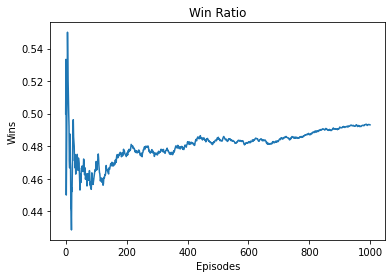

In [15]:
# plot win ratio
plt.plot(avg_win_ratio[1:])
plt.title('Win Ratio')
plt.xlabel('Episodes')
plt.ylabel('Wins')
plt.savefig('./q_wr.png', bbox_inches='tight')
plt.show()

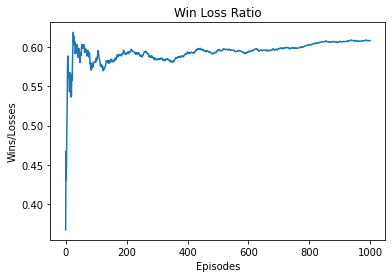

In [16]:
# plot win ratio
plt.plot(avg_win_ratio_no_ties[1:])
plt.title('Win Loss Ratio')
plt.xlabel('Episodes')
plt.ylabel('Wins/Losses')
plt.savefig('./q_wrnt.png', bbox_inches='tight')
plt.show()

In [17]:
# print counts
print('Total wins:', total_wins)
print('Total loss:', total_loss)
print('Total ties:', total_ties)

Total wins: 2468
Total loss: 1585
Total ties: 952


# Monte Carlo Tree Search

In [18]:
from copy import deepcopy

In [19]:
# randomly simulate game and return winner
def rollout(board, player):
    playing = True
    while playing:
        board, playing = random_move(board, player)
        player = (player % 2) + 1
    return find_winner(board)

In [20]:
# use montecarlo search to find best move
def pi(board, actions, num_trials):
    action_vals = []
    # try all actions
    for action in actions:
        # take action
        new_board = deepcopy(board)
        new_board, _ = agent_move(new_board, action)
        # estimate end reward
        reward = 0
        for i in range(num_trials):
            winner = rollout(new_board, 1)
            if winner == 1:
                reward -= 1
            elif winner == 2:
                reward += 1
        action_vals.append(reward/num_trials)
    # return best action
    return actions[np.argmax(action_vals)]

In [21]:
# simulate an episode
def simulate_episode(num_trials):
    # intialize board
    board, playing = init_board(), True
    # terminal state / no valid moves left
    player = np.random.randint(1,3) # who starts?
    while playing:
        # white move
        if player == 1:
            board, playing = random_move(board, 1)
        # black move
        elif player == 2:
            # current state
            state = board_to_state(board)
            # get all actions
            actions = get_actions(board, 2)
            # break if no moves left or white has run out of moves
            if len(actions) == 0:
                break
            # select action according to pi
            action = pi(board, actions, num_trials)
            # observe R, S'
            board, _ = agent_move(board, action)
        # alternate players
        player = (player % 2) + 1
    return find_winner(board)

In [22]:
# define parameters
num_eps = 100
num_trials = 5

In [23]:
# go through several episodes
wins = 0
loss = 0
ties = 0
win_ratio = np.zeros(num_eps)
win_ratio_no_ties = np.zeros(num_eps)
for t in range(num_eps):
    winner = simulate_episode(num_trials)
    if (winner == 2):
        wins += 1
    elif (winner == 1):
        loss += 1
    else:
        ties += 1
    win_ratio[t] = wins/(t+1)
    win_ratio_no_ties[t] = wins/(wins+loss+1)

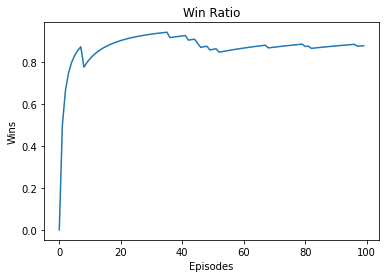

In [24]:
# plot win ratio
plt.plot(win_ratio)
plt.title('Win Ratio')
plt.xlabel('Episodes')
plt.ylabel('Wins')
plt.savefig('./mcts_wr.png', bbox_inches='tight')
plt.show()

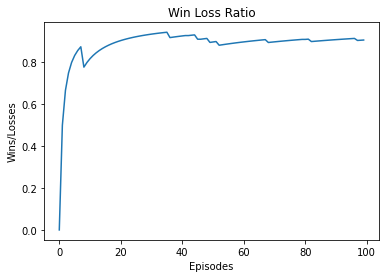

In [25]:
# plot win ratio
plt.plot(win_ratio_no_ties)
plt.title('Win Loss Ratio')
plt.xlabel('Episodes')
plt.ylabel('Wins/Losses')
plt.savefig('./mcts_wrnt.png', bbox_inches='tight')
plt.show()

In [26]:
# print counts
print('Total wins:', wins)
print('Total loss:', loss)
print('Total ties:', ties)

Total wins: 88
Total loss: 8
Total ties: 4
